<a href="https://colab.research.google.com/github/AndrewFatula/Hidden_markov_chain_and_Seq2seq_using_Google_Cloud_TPUv1-/blob/master/Seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import string
import os
import sys
import time
from nltk.tokenize import TweetTokenizer
import tensorflow as tf
from collections import Counter
from matplotlib import pyplot as plt
from nltk.translate import bleu_score
from keras import regularizers
from copy import deepcopy as dc
import tensorboardcolab as tb
print(tf.__version__)

2.0.0


Using TensorFlow backend.


Importing all needed packages.

In [0]:
!pip install --upgrade auth
!pip uninstall grpcio
!pip uninstall tensorflow
!pip install grpcio==1.24.3
!pip install tensorflow==2.0.0

Default version of tensorflow in colab is 1.15, so in order to gain all the benefits of tensorflow 2.0, current version of tensorflow needs to be uninstalled and then we can install the 2.0 version, but in order to use google cloud TPU v1 with tensorflow 2.0 before installing 2.0 version of tensorflow packages like grpcio and auth should be reinstalled the same way to versions specified above in code.

When given packages are reinstalled runtime have to be reset in order to activates updates.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Importing all needed tools and authentificating in google account in order to import data in colab.

In [0]:
downloaded = drive.CreateFile({'id':'1Z7odQLtZ7RmWERaRDJHDvbX_3VJ2ptvu'}) # all phrases in movies
downloaded.GetContentFile('movie_lines.txt') 
downloaded = drive.CreateFile({'id':'1TdbFyBvMGV_N8iszqTIAb7V1Vx_eSdMr'}) # all conversations in movies
downloaded.GetContentFile('movie_conversations.txt') 
downloaded = drive.CreateFile({'id':'1YTQeB3x_HTeEA5sjrleJD3notEKaPBnM'}) # all titles of movies
downloaded.GetContentFile('movie_titles_metadata.txt')


Loading all needed datafiles for constucting training dataset including GLOVE 50-demensional pretrained vector representations for 400000 English words trained on data from Twitter - which is needed in training seq2seq model to check phrases similarity

In [0]:



if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address iis', tpu_address)


cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
    tpu=tpu_address)
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

print ('Number of devices: {}'.format(tpu_strategy.num_replicas_in_sync))


TPU address iis grpc://10.33.193.226:8470
INFO:tensorflow:Initializing the TPU system: 10.33.193.226:8470


INFO:tensorflow:Initializing the TPU system: 10.33.193.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of devices: 8


Setting up TPU v1 hardware acceleration system. 
Definig TPU cluster_resolver and tpu_distributed_strategy for training seq2seq.

In [0]:

SEPARATOR = "+++$+++"
MAX_TOKENS_X = 12
MAX_TOKENS_Y = 10
MAX_TOKENS_CONV = 50
MIN_TOKEN_FREQ = 3

VEC_SIZE = 50

EMB_FILE = 'glove.6B.50d.txt'
GENRES = "horror,thriller,war"
WITH_EXCEPTION = True


def tokenize(str_):
	return TweetTokenizer(preserve_case=False).tokenize(str_)


def remove_all(str, substrings):
	index = 0
	for substr in substrings:
		length = len(substr)
		while str.find(substr) != -1:
			index = str.find(str)
			str = str[0 : index] + str[index + length:]
	return str



def load_movies(genres, exception = False):

	'''This function loads all the movie titles of specicfied genres 
		from <movie_titles_metadata.txt> file and returns list of movie titles'''


	movies = []
	with open("movie_titles_metadata.txt", 'rb') as gf:

		for line in gf:
			line = str(line, encoding='utf-8', errors='ignore')
			arr_line = list(map( lambda x: x.strip(), line.split(SEPARATOR) ))
			line_genres = list(map( lambda x: x.strip(" '"), arr_line[-1].strip("[]").split(",") ))
			append = True
   
			for genre in genres:
				if not exception:
					append = False
					if genre in line_genres:
						append = True
						break
				else:
					if genre in line_genres:
						append = False
						break

			if append:
				movies.append(arr_line[0])
				

	return movies				


def read_phrases(movies = [], genres = []):

	''' This function loads all phrasses from <movie_lines.txt> file which are 
			said in given movie list as an argument of this function
			If function is called with no argument than it reads phrasses 
			from all the movies available in dataset  '''

	phrases = {}

	with open('movie_lines.txt', 'rb') as lf:

		for line in lf:
			line = str(line, encoding='utf-8', errors='ignore').replace("<u>","").replace("</u>","")

			arr_line = list(map( lambda x: x.strip(), line.split(SEPARATOR) ))
			#phrases are loaded in dictionary, the key is index of a conversation
			
			if not movies:
				phrases[arr_line[0]] = tokenize(remove_all(arr_line[-1],
				                                           ["<b>","</b>","<u>","</u>","<i>","</i>","<u>", "</u>"]))
			elif arr_line[2] in movies: 
				phrases[arr_line[0]] = tokenize(remove_all(arr_line[-1],
				                                           ["<b>","</b>","<u>","</u>","<i>","</i>","<u>", "</u>"]))
	
	
	return phrases	
	


def read_dialogues(phrases, movies):

	''' this function constructs dialogs from phrases in the movies,
			all the needed information for dialogs construction is 
			readed from file <movie_conversations.txt>'''

	dialogues = []
	with open("movie_conversations.txt", 'rb') as df:

		for line in df:	
			line = str(line, encoding='utf-8', errors='ignore')
			arr_line = list(map( lambda x: x.strip(), line.split(SEPARATOR) ))
			dialog = list(map( lambda x: x.strip("' "), arr_line[-1].strip("[]").split(",") ))

			if not movies:
				dialogues.append([phrases[phrase] for phrase in dialog])
			elif arr_line[2] in movies:	
				dialogues.append([phrases[phrase] for phrase in dialog])

	return dialogues				


def get_phrase_pairs(genres = None, max_tokins = MAX_TOKENS_X, n_pairs = None, exception = False):

	''' This function constructs phrase_pairs dataset where each instance of 
		dataset is phrase and response to that phrase '''

	#when genres in not specified it read phrses from all the movies is available
	if genres == None:
		all_phrases = read_phrases()
		movies = []
	else:
		movies = load_movies(genres, exception = exception)
		all_phrases = read_phrases(movies, genres = genres)	
	
	#before constructing phrase pairs dataset we need to get conversations 
	#dataset from all readed phrases
	conversations = read_dialogues(all_phrases, movies)
	phrase_pairs = []

	for conv in conversations:
		prev_phrase = None

		biggest_len = 0
		for phrase in conv:
			if len(phrase) > biggest_len:
				biggest_len = len(phrase)
	
		if biggest_len > MAX_TOKENS_CONV:
			continue

		for phrase in conv:
			if prev_phrase is not None :
				phrase_pairs.append((prev_phrase, phrase))
			prev_phrase = phrase

	if not len(genres) == 0:
		if not exception:
			print("Total number of loaded phrases in " + ",".join(genres) + " movies is :", len(phrase_pairs))
		else:
			print("Total number of loaded phrases not in " + ",".join(genres) + " movies is :", len(phrase_pairs))		
	else:
		print("Total number of loaded phrases of all movies : " ,len(phrase_pairs))

	if (n_pairs == None) or (n_pairs >= len(phrase_pairs)) :
		return phrase_pairs, conversations
	else:
		np.random.shuffle(phrase_pairs)
		return phrase_pairs[0:n_pairs], conversations

	




Fuctions above are used to construct phrase_pairs dataset from movies

In [0]:








def word_corrector(word):

	''' this function is used to convert commonly used english words shortcuts 
		to corresponding them full forms '''

	dots = ['. ..', '. . .', '..', '. ...','...  ...', '.  ...', '. .']
	comonly_used = ["that", "what", "there", "who", "where", "how"]
	pronouns = ["it", "she", "he"]

	if word[-3:] == "'ll":
		decoded = [ word[:-3] , "will" ]
		return decoded

	elif word[-2:] == "'d":
		decoded = [ word[:-2] , "would" ]
		return decoded 

	elif word[-2:] == "'s" or word[-2:] == "s'": 
		if not word[:-2] in comonly_used+pronouns:
			decoded =  [ "someone" , "'" , "s" ]
		else:
			decoded = [word]
		return decoded

	elif word[-2:] == "'t":
		
		if word == "can't":
			decoded = [ "can" , "not" ]
		elif word == "won't":
			decoded = [ "will" , "not" ]
		else:
			decoded = [ word[:-3] , "not" ]	
		return decoded   

	elif word[-3:] == "'re":
		decoded = [ word[:-3] , "are" ]
		return decoded 

	elif word == "i'm":
		decoded = [ "i", "am" ]
		return decoded 

	elif word[-3:] == "'ve":
		decoded = [ word[:-3] , "have" ]
		return decoded 

	elif word[:2] == "y'":
		decoded = [ "you" , word[2:] ]
		return decoded

	elif word[:2] == "dont":
		decoded = [ "do" , "not" ]
		return decoded
	else:
		if word in dots:
			word = "..."
		elif word == "u":
			word = "you"
		elif word == "ur":
			word = "your"	

		return [word]

####### 
def get_word_dict2(phrase_pairs):

	''' this function constructs token dictionary with words which is available
		 in embeddings dictionary retrieved from GLOVE 50-dimensional wordvectors representations,
			and is present in phrase_pairs dataset with frequency >= than specified MIN_TOKEN_FREQ '''

	freq_count = Counter()
	sizes_x = []
	sizes_y = []

	for pair in phrase_pairs:
		if len(pair[0]) < MAX_TOKENS_X + 1 and len(pair[1]) < MAX_TOKENS_Y + 1:
			freq_count.update(pair[0])
			freq_count.update(pair[1])

	word_set = list(map(lambda x: '+' + x[0] if x[1] >= MIN_TOKEN_FREQ else '-' + x[0], freq_count.items() ))
	word_dict = {"EMPTY":0, "BEGIN":1, "END" : 2}
	i = 3
	n=0
	for word in word_set:
		if word[0] == "+":
			n+=1
			correct_word = word_corrector(word[1:])
   
			for corrected in correct_word:
				if not corrected in word_dict.keys() :
					word_dict[corrected] = i
					i+=1
	return word_dict



def convert_phrases2(phrase_pairs, word_dict):

	''' this function converts all the words in phrases dataset to tokens 
		based on token dictionary retrieved from embeddings file and phrase_pairs dataset,
			phrases with words which frequencies are < MIN_TOKEN_FREQ or with words which 
			are unavailable in words embeddings file are ignored,
			also it converts common words shortcuts in phrases to corresponding them full forms, 
			it returns converted to tokens phrase_pairs separately and lengths for each phrase in pair '''

	sizes_x = []
	sizes_y = []
	converted_x = []
	converted_y = []
	converted_x_reverse = []

	for pair in phrase_pairs:
		if len(pair[0]) < MAX_TOKENS_X + 1 and len(pair[1]) < MAX_TOKENS_Y + 1:
			phrase1 = []
			phrase2 = []
			phrase1_reverse = []
			for word in pair[0]:
				correct_word = word_corrector(word)

				for correct in correct_word:
					if correct in word_dict.keys():
						phrase1.append(word_dict[correct])
					else:
						phrase1.append(word_dict["EMPTY"])

			for word in pair[1]:
				correct_word = word_corrector(word)

				for correct in correct_word:
					if correct in word_dict.keys():
						phrase2.append(word_dict[correct])
					else:
						phrase2.append(word_dict["EMPTY"])

			phrase1 = [1] + phrase1 + [2]
			phrase2 = [1] + phrase2 + [2]
		
			if not word_dict["EMPTY"] in phrase1[1:] and not word_dict["EMPTY"] in phrase2[1:] and \
				 (not (len(phrase1) > MAX_TOKENS_X + 8 or len(phrase2) > MAX_TOKENS_Y + 8)):
				l1 = len(phrase1)
				for token_idx in range(l1):
					phrase1_reverse.append(phrase1[l1-token_idx-1])
	 
				converted_x.append(phrase1)
				converted_y.append(phrase2)
				converted_x_reverse.append(phrase1_reverse)

				sizes_x.append(len(phrase1))
				sizes_y.append(len(phrase2))
	
	length = len(sizes_x)
	sizes_x = np.array(sizes_x)
	sizes_y = np.array(sizes_y)

	return converted_x, converted_y, converted_x_reverse, sizes_x.astype(np.int32), sizes_y.astype(np.int32)

def calc_bleu_score(out, target):
	sf = bleu_score.SmoothingFunction()
	return bleu_score.sentence_bleu(target, out, smoothing_function=sf.method1, weights=(0.5, 0.5))


def get_words_from_tokens(sentence, token_dict):
	return [token_dict[value] for value in sentence]





	


functions above are used to prepare and preprocces phrase_pairs dataset for training

In [0]:


print("constructing vectorspace for pharse pairs dataset...")

phrase_pairs, dialogues = get_phrase_pairs(genres = GENRES.split(","), exception = WITH_EXCEPTION)
phrase_pairs = make_addition(phrase_pairs)
word_dict = get_word_dict2(phrase_pairs)


phrase_number = len(phrase_pairs)
inverse_word_dict = {}

for key in word_dict.keys():
  inverse_word_dict[word_dict[key]] = key

inverse_emb_dict = {}


print("phrases are loaded")


constructing vectorspace for pharse pairs dataset...
Total number of loaded phrases not in horror,thriller,war movies is : 101717
phrases are loaded


Code above reads and filters phrase pairs for training dataset.


In [0]:
print("preparing and preprocces dataset...")

converted_x, converted_y, converted_x_reverse, true_lengths_x, true_lengths_y = convert_phrases2(phrase_pairs, word_dict)

width_x = int(max(true_lengths_x))
width_y = int(max(true_lengths_y))

sparse_x = np.zeros((len(true_lengths_x), width_x))
sparse_y = np.zeros((len(true_lengths_x), width_y))
sparse_x_reverse = np.zeros((len(true_lengths_x), width_x))
semi_hot_y = np.zeros((len(true_lengths_x), width_y))


#padding each sequence in x_data and y_data
for i in range(len(true_lengths_x)):
    sparse_x[i, : true_lengths_x[i]] = np.array(converted_x[i])
    sparse_y[i, : true_lengths_y[i]] = np.array(converted_y[i])
    sparse_x_reverse[i, : true_lengths_x[i]] = np.array(converted_x_reverse[i])
    semi_hot_y[i, : true_lengths_y[i]] = np.ones((true_lengths_y[i]))

#semi_hot_y is needed to mask not needed losses of empty elements in sequence

length = len(true_lengths_x)

#lengths_x_one_hot is needed to mask hidden states retrieved from empty part of x sequence
lengths_x_onehot = tf.one_hot(np.array(true_lengths_x) - 1, width_x)

# and now we need to get rid of extra words in word_dict after we filtered phrase_pairs by lengths and unknown words 
# and convert phrases without extra tokens corresponding to those words
unique_tokens = np.unique(np.concatenate((np.unique(sparse_x), np.unique(sparse_y)), axis = 0))
transfer_tokens = {}
transfer_dict = {}

for key in word_dict.keys():
    inverse_word_dict[word_dict[key]] = key


for i in range(len(unique_tokens)):
    transfer_tokens[unique_tokens[i]] = i
    transfer_dict[inverse_word_dict[unique_tokens[i]]] = i

inverse_word_dict = {}

for key in transfer_dict.keys():
    inverse_word_dict[transfer_dict[key]] = key

word_dict = transfer_dict

for i in range(length):
    for j in range(width_x):
        sparse_x[i,j] = transfer_tokens[sparse_x[i,j]]
        sparse_x_reverse[i,j] = transfer_tokens[sparse_x_reverse[i,j]]

    for k in range(width_y):
        sparse_y[i,k] = transfer_tokens[sparse_y[i,k]]

sparse_x = tf.convert_to_tensor(sparse_x, dtype = tf.int32)  
sparse_y = tf.convert_to_tensor(sparse_y, dtype = tf.int32) 
sparse_x_reverse = tf.convert_to_tensor(sparse_x_reverse, dtype = tf.int32)  
semi_hot_y = tf.convert_to_tensor(semi_hot_y, dtype = tf.int32)

dict_size = len(list(word_dict.values()))    


print("original dict_size:", dict_size)
print("number of phrase_pairs:", length)
print("min word frequency:", MIN_TOKEN_FREQ)
print("max phrase1 length:", MAX_TOKENS_X)
print("max phrase2 length:", MAX_TOKENS_Y)
print("data is ready")

preparing and preprocces dataset...
original dict_size: 6271
number of phrase_pairs: 33538
min word frequency: 3
max phrase1 length: 12
max phrase2 length: 10
data is ready


In [0]:
weights = []
weights.append(seq2seq.emb_layer.get_weights())
weights.append(seq2seq.decoder.get_weights())
weights.append(seq2seq.encoder.get_weights())
weights.append(seq2seq.interpreter.get_weights())

As well as TPU v1 can be executed only with static computational graph, recurrent layers have to be unrolled to train on TPU, as it needs to be unrolled all the training data must have fixed shape. 

In order to train seq2seq model with variable size input sequences, lenghts of train instances are encoded as one_hot for x_sequence vectors and semi_hot vectors for y_sequence (semi_hot means vector of ones of sequence lengths and zeroes for the rest).

This vectors are multiplied with network output during training so non-zero gradient for each sequence will have variable lengths as training sequences and rest of the gradients will be zero.


In [0]:
with tpu_strategy.scope():


    class Seq2Seq(tf.keras.Model):

        ''' inherited from tf.keras.model class simle seq2seq model class with one embedding layer, 2 recurrent layers and two dense layers  '''

        def __init__(   self, hidden_size, emb_size, 
                        word_dict, inverse_word_dict ):

            super(Seq2Seq, self).__init__()
            self.dict_size = len(word_dict)
            self.hidden_size = hidden_size
            self.emb_size = emb_size
            self.word_dict = word_dict
            self.inverse_word_dict = inverse_word_dict

            self.emb_layer = tf.keras.layers.Embedding(self.dict_size, emb_size)

            self.decoder = tf.keras.layers.LSTM( units = hidden_size, recurrent_activation = "sigmoid",
                                                kernel_regularizer=regularizers.l2(0.003),
                                                recurrent_regularizer=regularizers.l2(0.003), 
                                                bias_regularizer=regularizers.l2(0.003),
                                                dropout = 0.05, recurrent_dropout = 0,
                                                return_state = True, return_sequences = True, 
                                                unroll = True )
            
            self.encoder = tf.keras.layers.LSTM( units = hidden_size, recurrent_activation = "sigmoid",
                                               kernel_regularizer=regularizers.l2(0.003), 
                                               recurrent_regularizer=regularizers.l2(0.003),
                                               bias_regularizer=regularizers.l2(0.003),
                                                dropout = 0, recurrent_dropout = 0, 
                                               return_state = True, unroll = True )
            
            self.encoder_reverse = tf.keras.layers.GRU( units = hidden_size, recurrent_activation = "sigmoid", 
                                                       kernel_regularizer=regularizers.l2(0.003), 
                                                       recurrent_regularizer=regularizers.l2(0.003), 
                                                       bias_regularizer=regularizers.l2(0.003),
                                                        dropout = 0, recurrent_dropout = 0, 
                                                       return_state = True, unroll = True )
            
            self.interpreter = tf.keras.Sequential([ tf.keras.layers.Dense(self.dict_size) ])
            self.end_words = ["."]


        def get_words(self, tokens):

            '''fucntion that returns words from output tokens'''

            words = []
            prev_token = None
            for token in tokens:
                if token != prev_token:
                    words.append(self.inverse_word_dict[token])
                    prev_token = token
                    
            return words



        def encode_sequence(self, x_batch, x_batch_reverse, one_hot_x, seq_len, train):

            ''' encode sequence method, that returns hidden state for encoder for each input x_sequence'''

            batch_size = np.shape(x_batch)[0]
            hidden_total = tf.zeros([batch_size, self.hidden_size])
            hidden_state = tf.zeros([batch_size, self.hidden_size])
            hidden_total_reverse = tf.zeros([batch_size, self.hidden_size])
            hidden_state_reverse = tf.zeros([batch_size, self.hidden_size])
            for i in range(seq_len):
                _ , hidden_state, hidden_state_reverse = self.encoder(x_batch[:,i:i+1], [hidden_state, hidden_state_reverse], training = train)
                hidden_total += one_hot_x[:,i,None] * hidden_state
                hidden_total_reverse += one_hot_x[:,i,None] * hidden_state_reverse
            return [hidden_total, hidden_total_reverse]


        def decode_sequence(self, hidden, y_batch, train ):

            ''' method for training seq2seq with teacher 
                witch takes as argument encoded hidden state from x_input sequence
            '''

            output, _, _ = self.decoder(y_batch, hidden, training = train)
            return self.interpreter(output)


        def decode_chain_sequence_argmax(self, hidden, seq_len, train):

            ''' method for training seq2seq without teacher 
                that takes as argument encoded hidden state and generates output as a chain sequence
            '''

            total_output = []
            batch_size = np.shape(hidden[0])[0]
            current_emb =  self.emb_layer(tf.ones((batch_size, 1)))

            for i in range(seq_len):
                output, hidden_h, hidden_c = self.decoder(current_emb, hidden, training = train)
                hidden = [hidden_h, hidden_c]
                current_distribution = self.interpreter(output)
                total_output.append(current_distribution)
                current_word = tf.argmax(current_distribution, axis=-1)
                current_emb = self.emb_layer(current_word)

            return tf.concat(total_output, axis = 1)


        def decode_chain_sequence_sample(self, hidden, seq_len, train):

            ''' method for training seq2seq without teacher 
                that takes as argument encoded hidden state and generates output as a chain sequence
            '''

            total_output = []
            batch_size = np.shape(hidden[0])[0]
            current_emb =  self.emb_layer(tf.ones((batch_size, 1)))
            sampled_tokens = []

            for i in range(seq_len):
                output, hidden_h, hidden_c = self.decoder(current_emb, hidden, training = train)
                hidden = [hidden_h, hidden_c]
                current_distribution = self.interpreter(output)
                total_output.append(current_distribution)
                current_word = tf.random.categorical(current_distribution[:,0,:], 1)
                sampled_tokens.append(current_word)
                current_emb = self.emb_layer(current_word)

            return tf.concat(total_output, axis = 1), tf.concat(sampled_tokens, axis = 1)


        def call(self, input_x, input_x_reverse, input_y, one_hot_x, train = True):

            ''' forward method for training with teacher'''

            seq_len_x = np.shape(input_x)[1]
            input_x_reverse = self.emb_layer(input_x_reverse)
            input_x = self.emb_layer(input_x)
            input_y = self.emb_layer(input_y)
            hidden = self.encode_sequence(input_x, input_x_reverse, one_hot_x, seq_len_x, train)
            predictions = self.decode_sequence(hidden, input_y, train)
            return predictions


        def call_2(self, input_x, input_x_reverse, one_hot_x, seq_len_y, train = True):

            ''' forward method for training without teacher'''

            seq_len_x = np.shape(input_x)[1]
            input_x_reverse = self.emb_layer(input_x_reverse)
            input_x = self.emb_layer(input_x)
            hidden = self.encode_sequence(input_x, input_x_reverse, one_hot_x, seq_len_x, train)
            predictions = self.decode_chain_sequence_argmax(hidden, seq_len_y, train)
            return predictions


        def call_sample(self, input_x, input_x_reverse, one_hot_x, seq_len_y, train = True):

            ''' forward method for training without teacher'''

            seq_len_x = np.shape(input_x)[1]
            input_x_reverse = self.emb_layer(input_x_reverse)
            input_x = self.emb_layer(input_x)
            hidden = self.encode_sequence(input_x, input_x_reverse, one_hot_x, seq_len_x, train)
            predictions, sampled_tokens = self.decode_chain_sequence_sample(hidden, seq_len_y, train)
            return predictions, sampled_tokens



        def save(self):
            weights = []
            weights.append(self.emb_layer.get_weights())
            weights.append(self.decoder.get_weights())
            weights.append(self.encoder.get_weights())
            for layer in self.interpreter.layers:
                weights.append(layer.get_weights())
            return weights





        def decode_chain_sequence_test(self, hidden, r = 0, sampling = False):

            ''' method applied to trained seq2seq that generate output sequence for each input phrase ''' 

            current_emb =  self.emb_layer(tf.ones((1, 1)))
            total_output = []

            if r > 0:
                current_emb += tf.convert_to_tensor(np.random.rand(1, self.emb_size), dtype = tf.float32) * 0.1 * r

            for _ in range(15):
                output, hidden_h, hidden_c = self.decoder(current_emb, hidden, training = False)
                hidden = [hidden_h, hidden_c]
                current_distribution = self.interpreter(output)
                if sampling:
                    current_word = tf.random.categorical(current_distribution[0,:,:], 1)
                else:
                    current_word = tf.argmax(current_distribution, axis = -1 )
                if (self.inverse_word_dict[current_word.numpy()[0,0]] == "END" ) or \
                    (self.inverse_word_dict[current_word.numpy()[0,0]] == "EMPTY"):
                    if len(total_output) < 1:
                        return self.decode_chain_sequence_test(hidden, r+1)
                    else:
                        return total_output

                total_output.append(current_word.numpy()[0,0])  
                current_emb = self.emb_layer(current_word)
                r = 0

            return total_output  


        def encode_sequence_test(self, x, x_reverse):

            ''' method applied to trained seq2seq model, returns hidden state for each input sequence'''

            _ , hidden, hidden_reverse = self.encoder(x[None, :, :], training = False )
            return [hidden, hidden_reverse]  




        def predict(self, phrase, sampling = False):

            ''' method applied on trained seq2seq that returns output phrase on each input phrase'''
            
            phrase_tokens = []

            for word in phrase:
                if word in self.word_dict.keys():
                    phrase_tokens.append(self.word_dict[word])

            phrase_tokens = phrase_tokens
            phrase_tokens_reverse = [phrase_tokens[len(phrase_tokens)-1-i] for i in range(len(phrase_tokens))]

            inputs = []
            inputs_reverse = []

            for word in phrase_tokens:
                inputs.append(self.emb_layer(word))
            
            for word in phrase_tokens_reverse:
                inputs_reverse.append(self.emb_layer(word))

            inputs = tf.convert_to_tensor(inputs, dtype = tf.float32)
            inputs_reverse = tf.convert_to_tensor(inputs_reverse, dtype = tf.float32)
            hidden = self.encode_sequence_test(inputs, inputs_reverse)
            output = self.decode_chain_sequence_test(hidden, sampling = sampling)
            output_words = self.get_words(output)

            return output_words



In code above class of seq2seq model for training is subclassed from tf.keras.model class

In [0]:

with tpu_strategy.scope():

    def ngramm_recall_score( predictions, labels,
                                semi_hot_y,
                                seq_len,
                                weights = tf.convert_to_tensor([1.,1.,1.,1.]) ):
        
        max_seq_len = np.shape(labels)[1]
        batch_size = np.shape(labels)[0]
        lengths = tf.where(tf.equal(predictions, 2), 1., 0.) * \
                            tf.range(0, max_seq_len, dtype = tf.float32)[None, :]
        lengths  += tf.cast(tf.where(tf.equal(predictions, 2), 
                                     0., max_seq_len), dtype = tf.float32)
        lengths = tf.reduce_min(lengths, axis = 1)
        semihot_predictions = tf.ones((batch_size, max_seq_len), dtype = tf.float32) * \
                                        tf.range(0, max_seq_len, dtype = tf.float32)[None, :]
        semihot_predictions = tf.where(semihot_predictions <= lengths[:, None], 1., 0.)
        predictions = tf.cast(predictions, tf.int32)
        labels = tf.cast(labels, tf.int32)

        n1_gramms = 0
        for token_idx in range(max_seq_len):
            n1_gramms += tf.math.sign( tf.reduce_sum( tf.where(tf.equal(labels[ :, token_idx : token_idx + 1], 
                                                                        predictions), 1., 0.) * \
                                                     semi_hot_y[ :, token_idx : token_idx + 1] * \
                                                     semihot_predictions , axis = 1) )
        n1_gramms /= seq_len
            
        n2_gramms = 0
        for token_idx in range(max_seq_len-1):
            n2_gramms += tf.math.sign( tf.reduce_sum( tf.where(tf.equal(labels[ :, token_idx : token_idx + 1], predictions[:,:-1]), 1., 0.) * \
                                                     semi_hot_y[:, token_idx : token_idx + 1] * \
                                                      tf.where(tf.equal(labels[ :, token_idx + 1 : token_idx + 2], predictions[:,1:]), 1., 0.) * \
                                                      semi_hot_y[:, token_idx + 1 : token_idx + 2] *\
                                                      semihot_predictions[:,1:] , axis = 1) )
        n2_gramms /= tf.maximum((seq_len - 1.), 1.)

        n3_gramms = 0
        for token_idx in range(max_seq_len-2):
            n3_gramms += tf.math.sign( tf.reduce_sum( tf.where( tf.equal(labels[ :, token_idx : token_idx + 1], 
                                                                        predictions[:,:-2]), 1., 0. ) * \
                                                    semi_hot_y[ :, token_idx : token_idx + 1] * \
                                                      tf.where( tf.equal(labels[ :, token_idx + 1 : token_idx + 2], 
                                                                        predictions[:,1:-1]), 1., 0. ) * \
                                                     semi_hot_y[ :, token_idx + 1 : token_idx + 2] * \
                                                      tf.where( tf.equal(labels[ :, token_idx + 2 : token_idx + 3],
                                                                        predictions[:,2:]), 1., 0. ) * \
                                                     semi_hot_y[ :, token_idx + 2 : token_idx + 3]  * \
                                                      semihot_predictions[:,2:] , axis = 1) )      
        n3_gramms /= tf.maximum((seq_len - 2.), 1.)

        n4_gramms = 0
        for token_idx in range(max_seq_len-3):
            n4_gramms += tf.math.sign( tf.reduce_sum( tf.where(tf.equal(labels[ :, token_idx : token_idx + 1],
                                                                        predictions[:,:-3]), 1., 0.) * \
                                                     semi_hot_y[ :, token_idx : token_idx + 1] * \
                                                      tf.where(tf.equal(labels[ :, token_idx + 1 : token_idx + 2], 
                                                                        predictions[:,1:-2]), 1., 0.) * \
                                                     semi_hot_y[ :, token_idx + 1 : token_idx + 2] * \
                                                      tf.where(tf.equal(labels[ :, token_idx + 2 : token_idx + 3], 
                                                                        predictions[:,2:-1]), 1., 0.) * \
                                                     semi_hot_y[ :, token_idx + 2 : token_idx + 3] * \
                                                      tf.where(tf.equal(labels[ :, token_idx + 3 : token_idx + 4], 
                                                                        predictions[:,3:]), 1., 0.) * \
                                                      semi_hot_y[ :, token_idx + 3 : token_idx + 4] * \
                                                      semihot_predictions[:,3:] , axis = 1) )
        n4_gramms /= tf.maximum((seq_len - 3.), 1.)

        labels_lengths = tf.reduce_sum(semi_hot_y, axis = 1)
        predictions_lengths = tf.reduce_sum(semihot_predictions, axis = 1)
        len_diff = tf.where(labels_lengths < predictions_lengths, predictions_lengths - labels_lengths, 0)

        recall_penalty = 1 / (1.5/(1.5+tf.math.exp(-len_diff/2)))
        recall_penalty /= tf.reduce_max(recall_penalty)

        n_gramms = tf.stack([n1_gramms, n2_gramms, n3_gramms, n4_gramms], axis = 1)
        weights /=tf.reduce_sum(weights)

        return tf.reduce_sum(n_gramms*weights[None,:], axis = 1)*recall_penalty
        




One of the most eficcient metrics to evaluate similarity between two sentences is Bleu score ot Bilingual evaluation understudy score, with calculates modified precision of two sencences based of n_gramms precision, in code above is implemented function which calculates BLEU score for multiple sentences in parallel.

In [0]:


with tpu_strategy.scope():


	def get_argmax_recall(labels, predictions, semi_hot_y, seq_lens):

		predictions_argmax = tf.stop_gradient(tf.argmax(predictions, axis = -1))
  
		argmax_recall = ngramm_recall_score( predictions_argmax, labels,
											semi_hot_y,
											seq_lens )
  
		return tf.nn.compute_average_loss(argmax_recall, global_batch_size=BATCH_SIZE)



	def compute_loss1(labels, predictions, 
						semi_hot_y):

		''' cross_entropy_loss function for distributed strategy'''

		per_example_loss = loss_object(labels, predictions)*semi_hot_y
		return tf.nn.compute_average_loss(per_example_loss , global_batch_size=BATCH_SIZE)



	def compute_loss2(labels, predictions_probabilities_argmax, predictions_probabilities_sample,
						sampled_tokens,
						semi_hot_y,
						seq_lens):

		'''log_probability loss for correcting output probalility distribution for distributed strategy'''

		probabilities_no_grad = tf.stop_gradient(predictions_probabilities_argmax)
		argmax_tokens = tf.stop_gradient(tf.cast(tf.argmax(probabilities_no_grad, axis = -1), tf.float32))
		sampled_tokens = tf.stop_gradient(tf.cast(sampled_tokens, tf.float32))
  
		labels = tf.cast(labels, tf.float32)
		batch_size = np.shape(labels)[0]
		max_seq_len = np.shape(labels)[1]
		semihot_sampled = []
		sample_recall = []
        
		for idx in range(np.shape(sampled_tokens)[0]):
			
			sampled_lengths = tf.where(tf.equal(sampled_tokens[idx, :, :], 2), 1., 0.) * \
								tf.range(0, max_seq_len, dtype = tf.float32)[None, :]

			sampled_lengths  += tf.cast(tf.where(tf.equal(sampled_tokens[idx, :, :], 2),
			                                     0., max_seq_len), dtype = tf.float32)
   
			sampled_lengths = tf.reduce_min(sampled_lengths, axis = 1)
			semihot_sampled_ = tf.ones((batch_size, max_seq_len), dtype = tf.float32) * \
								tf.range(0, max_seq_len, dtype = tf.float32)[None, :]

			semihot_sampled.append(tf.where(semihot_sampled_ <= sampled_lengths[:, None], 1., 0.))
			sample_recall.append(ngramm_recall_score( sampled_tokens[idx, :, :], labels,
                                						semi_hot_y,
                                						seq_lens ))
  
		argmax_recall = ngramm_recall_score( argmax_tokens, labels,
                                						semi_hot_y,
                                						seq_lens )
		log_probabilities_corrector = []
		for idx in range(np.shape(sampled_tokens)[0]):
			recall_corrector = tf.where( argmax_recall < 0.97, sample_recall[idx] - argmax_recall , 0. )
   
			gathered_sample_probabilities = tf.gather_nd( - tf.nn.log_softmax(predictions_probabilities_sample[idx,:,:],
			                                            						axis = -1) , 
			                                            tf.cast(sampled_tokens[idx,:,:], tf.int32)[:,:,None],
														        batch_dims = 2)
   
			log_probabilities_corrector.append(gathered_sample_probabilities  * \
			                                   recall_corrector[:, None] * \
											    semihot_sampled[idx] )
   
		log_probabilities_corrector = tf.concat(log_probabilities_corrector, axis = 0)
		sample_recall = tf.concat(sample_recall, axis = 0)
		return tf.nn.compute_average_loss(log_probabilities_corrector, 
		                                  global_batch_size=BATCH_SIZE*np.shape(sampled_tokens)[0]),  \
               tf.nn.compute_average_loss(sample_recall, global_batch_size=BATCH_SIZE*np.shape(sampled_tokens)[0]), \
               tf.nn.compute_average_loss(argmax_recall, global_batch_size=BATCH_SIZE)



	### For each training method corresponding distributed training step function needs to be constructed 

	def distributed_train_step1(dataset_inputs):

		''' function that applies distriuted TPU strategy to train_step1 function'''

		per_replica_losses = tpu_strategy.experimental_run_v2(train_step1,
															args=(dataset_inputs,))
		return tpu_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
													axis=None)

	def distributed_train_step2(dataset_inputs):

		''' function that applies distriuted TPU strategy to train_step2 function'''

		per_replica_losses = tpu_strategy.experimental_run_v2(train_step2,
															args=(dataset_inputs,))
		return tpu_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
													axis=None)

	def distributed_correction(dataset_inputs):

		''' function that applies distriuted TPU strategy to train_step3 function'''

		per_replica_losses = tpu_strategy.experimental_run_v2(dist_correction,
															args=(dataset_inputs,))
		return tpu_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
													axis=None)


	@tf.function
	def train_step1(inputs):

		''' train_step1 fuction for crossentropy teacher training method 
			with @tf.function decorator that assures construction of static computation graph for training
			function returns crosscntropy_loss regardless wich loss was 
			applied at training step in order to track loss value during training loop
		'''
		input_x = inputs[0]
		input_x_reverse = inputs[1]
		input_y = inputs[2]
		one_hot_x = inputs[3]
		semi_hot_y = tf.cast(inputs[4], tf.float32)
		with tf.GradientTape() as tape:
			predictions = seq2seq(input_x, input_x_reverse, input_y[:,:-1], one_hot_x)
			loss = compute_loss1(input_y[:,1:], predictions, semi_hot_y[:,1:])
		gradients = tape.gradient(loss, seq2seq.trainable_variables)
		optimizer1.apply_gradients(zip(gradients, seq2seq.trainable_variables))
		return loss


	@tf.function
	def train_step2(inputs):

		''' train_step2 fuction for crossentropy chain_sequence training method 
		'''
		input_x = inputs[0]
		input_x_reverse = inputs[1]
		input_y = inputs[2]
		one_hot_x = inputs[3]
		semi_hot_y = tf.cast(inputs[4], tf.float32)
		seq_lens = tf.reduce_sum(semi_hot_y[:,1:], axis = 1)
		with tf.GradientTape() as tape:
			predictions = seq2seq.call_2(input_x, input_x_reverse, one_hot_x, np.shape(input_y)[1]-1)
			loss = compute_loss1(input_y[:,1:], predictions, semi_hot_y[:,1:])
			argmax_recall = get_argmax_recall(input_y[:,1:], predictions, semi_hot_y[:,1:], seq_lens)
		gradients = tape.gradient(loss, seq2seq.trainable_variables)
		optimizer2.apply_gradients(zip(gradients, seq2seq.trainable_variables))

		train_accuracy(input_y[:,1:], tf.keras.activations.softmax(predictions, axis = -1) *
					semi_hot_y[:,1:,None] + (1-semi_hot_y)[:,1:,None ] * \
					tf.one_hot(0,seq2seq.dict_size)[None, None,:]) 
  		# in order to get correct accuracy we need to mask padded values

		return tf.stack([loss, argmax_recall])

	@tf.function
	def dist_correction(inputs):

		''' dist_correction fuction performs output distribution correction based on word2wec 
		'''

		input_x = inputs[0]
		input_x_reverse = inputs[1]
		input_y = inputs[2]
		one_hot_x = inputs[3]
		semi_hot_y = tf.cast(inputs[4], tf.float32)
		seq_lens = tf.reduce_sum(semi_hot_y[:,1:], axis = 1)
		predictions_sample = []
		sampled_tokens = []
		with tf.GradientTape() as tape:
			predictions_argmax = seq2seq.call_2(input_x, input_x_reverse, 
			                                    one_hot_x, np.shape(input_y)[1]-1, train = False)
			for _ in range(15):
				sampled_values = seq2seq.call_sample(input_x, input_x_reverse, 
				                                     one_hot_x, np.shape(input_y)[1]-1, train = False)
				predictions_sample.append(sampled_values[0])
				sampled_tokens.append(sampled_values[1])
			predictions_sample = tf.stack(predictions_sample, axis = 0)
			sampled_tokens = tf.stack(sampled_tokens, axis = 0)
			loss, sample_recall, argmax_recall = compute_loss2(input_y[:,1:], 
			                                    predictions_argmax, predictions_sample, sampled_tokens, semi_hot_y[:,1:], seq_lens)
			print_loss = tf.stop_gradient(compute_loss1(input_y[:,1:], predictions_argmax, semi_hot_y[:,1:]))
		gradients = tape.gradient(loss, seq2seq.trainable_variables, )
		optimizer3.apply_gradients(zip(gradients, seq2seq.trainable_variables))
  
		train_accuracy(input_y[:,1:], tf.keras.activations.softmax(predictions_argmax, axis = -1) *
		                 semi_hot_y[:,1:,None] + (1-semi_hot_y)[:,1:,None] * 
						           tf.one_hot(0,seq2seq.dict_size)[None, None,:]) 
  		# in order to get correct accuracy we need to mask padded values

		return tf.stack([print_loss, sample_recall, argmax_recall], axis = 0)





Above are defined 3 different loss function for training seq2seq model:
  1. cross_entropy los function for teacher training method
  2. cross_entropy loss function for chain training method
  2. probability correction loss function for correcting output probability distribution over, this loss function is applied to sampled sequence rather than argmax and is baed on calculating recall score between labels and sampled sentence

In [0]:
 with tpu_strategy.scope():

    def crossentropy_training_loop( train_dist_dataset, 
                                    teacher_prob,
                                    mean_pre_loss, argmax_recals ):

        ''' training function for crossentropy training loop
        '''

        for x in train_dist_dataset:
            if np.random.rand() < teacher_prob:
                loss = distributed_train_step1(x)
            else:
                track_values = distributed_train_step2(x)
                loss2 = track_values[0]
                argmax_recal = track_values[1]
                mean_pre_loss.append(loss2)
                argmax_recals.append(argmax_recal)
        
            if teacher_prob == 1:
                mean_pre_loss.append(loss)


    def correction_training_loop( train_dist_dataset, 
                                    teacher_prob,
                                    mean_pre_loss, mean_sample_bleu, mean_argmax_bleu ):

        ''' training function for crossentropy training loop
        '''

        for x in train_dist_dataset:


            track_values = distributed_correction(x)
            loss = track_values[0]
            sample_bleu = track_values[1]
            argmax_bleu = track_values[2]

            mean_pre_loss.append(loss)
            mean_sample_bleu.append(sample_bleu)
            mean_argmax_bleu.append(argmax_bleu)


                



			

Training circle functions for cross_entropy training method and probability correction is defined in code above

In [0]:
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 1024
BATCH_SIZE = 2048



tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(1)

with tpu_strategy.scope():

	def relu(x):
		if x < 0:
			return 0
		else:
			return x


	
	#instanciating seq2seq model from seq2seq class
	#seq2seq = Seq2Seq( HIDDEN_SIZE, EMBEDDING_SIZE,
	#				   word_dict, inverse_word_dict )

	
	train_length = np.shape(sparse_x)[0]
	train_steps = int(train_length/BATCH_SIZE)

	#defining tf_callbacks and evaluation metrices
	train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
	null_train_acc = np.mean(np.sum(1-semi_hot_y, axis = 1)-1)/np.shape(sparse_y)[1]

	train_losses = []
	train_accuracies = []
	teacher_method_losses=[]

	train_correction_accuracies = []
	correction_sample_recall = []
	correction_argmax_recall = []
	

	LEARNING_RATE = tf.keras.optimizers.schedules.ExponentialDecay(0.0005, decay_steps = train_steps, decay_rate = 0.985, staircase= True)
	LEARNING_RATE2 = tf.keras.optimizers.schedules.ExponentialDecay(7e-5, decay_steps = train_steps*4, decay_rate = 1.1, staircase= True)    

	loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction=tf.keras.losses.Reduction.NONE)

	optimizer1 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
	optimizer2 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
	optimizer3 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE2)
	optimizer4 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE2)

	n_epochs = 79
	is_cross_entropy = True
	teacher_prob = 0
	print("crossentropy training ... ")
	for epoch in range(n_epochs):
		epoch_start = time.localtime(time.time())
		
		mean_pre_loss = [0]
		mean_sample_recall = []
		mean_argmax_recall = []

		# in order to make training independent from instances order in batches, 
		#distributed training dataset have to be shuffled and reconstructed every epoch during training
		dataset = tf.data.Dataset.from_tensor_slices((sparse_x, sparse_x_reverse, 
		                                              sparse_y, lengths_x_onehot,
													    semi_hot_y)).shuffle(150000).batch(BATCH_SIZE, drop_remainder = True) 
				 
		train_dist_dataset = tpu_strategy.experimental_distribute_dataset(dataset)
  
		if epoch == 590:
			print("distribution correction training...")
			teacher_prob = 0
			is_cross_entropy = False

		if(epoch + 1) % 40 == 0 and is_cross_entropy:
			teacher_prob = 1 - teacher_prob

		if is_cross_entropy:    

			crossentropy_training_loop( train_dist_dataset, 
										teacher_prob, 
										mean_pre_loss, mean_argmax_recall)
		else:

			correction_training_loop( train_dist_dataset, 
										teacher_prob, 
										mean_pre_loss, mean_sample_recall, mean_argmax_recall)

		epoch_end = time.localtime(time.time())
		start_in_sec = epoch_start[3]*3600 + epoch_start[4]*60 + epoch_start[5]
		end_in_sec = epoch_end[3]*3600 + epoch_end[4]*60 + epoch_end[5]
		epoch_time = end_in_sec - start_in_sec

		train_loss = np.mean(mean_pre_loss)
		train_acc = relu((train_accuracy.result().numpy()-null_train_acc)/(1-null_train_acc))
		train_accuracy.reset_states()

		if is_cross_entropy:
			if not teacher_prob == 1:
				argmax_recall = np.mean(mean_argmax_recall)
				correction_argmax_recall.append(argmax_recall)
				train_losses.append(train_loss)
				train_accuracies.append(train_acc)
	
				print("Epoch: ", epoch,", Train loss:", train_loss, 
				      ", Train accuracy:", train_acc, 
					     ", argmax_recall_score:", argmax_recall, 
						    ", teacher_prob:", teacher_prob,", time: ", 
							   epoch_time ," sec ")

			else:
				teacher_method_losses.append(train_loss)
				print("Epoch: ", epoch,", Train loss:",
				      train_loss, ", Train accuracy:",
					     train_acc, ", teacher_prob:", 
						    teacher_prob,", time: ",
							   epoch_time ," sec ")
	
	

		else:
			sample_recall = np.mean(mean_sample_recall)
			argmax_recall = np.mean(mean_argmax_recall)
			print("Epoch: ", epoch,", Train loss:",
			      train_loss, ", Train accuracy:", 
				     train_acc, ", sample_recall_score:", 
					    sample_recall, ", argmax_recall_score:",
						   argmax_recall, ", time: ",
						   epoch_time ," sec ")	

			train_correction_accuracies.append(train_acc)
			correction_sample_recall.append(sample_recall)
			correction_argmax_recall.append(argmax_recall)
   

	
				
		



crossentropy training ... 
Epoch:  0 , Train loss: 4.84873171413646 , Train accuracy: 0.8810123019142041 , argmax_recall_score: 0.80986917 , teacher_prob: 0 , time:  22  sec 
Epoch:  1 , Train loss: 3.3076862868140724 , Train accuracy: 0.8866508689462183 , argmax_recall_score: 0.8082433 , teacher_prob: 0 , time:  2  sec 
Epoch:  2 , Train loss: 2.843006035860847 , Train accuracy: 0.8891175003098675 , argmax_recall_score: 0.8061794 , teacher_prob: 0 , time:  2  sec 
Epoch:  3 , Train loss: 2.6492491609909954 , Train accuracy: 0.890301810436445 , argmax_recall_score: 0.80372894 , teacher_prob: 0 , time:  2  sec 
Epoch:  4 , Train loss: 2.56414831385893 , Train accuracy: 0.891282474027915 , argmax_recall_score: 0.8039131 , teacher_prob: 0 , time:  3  sec 
Epoch:  5 , Train loss: 2.523783599629122 , Train accuracy: 0.8920782756263114 , argmax_recall_score: 0.8036523 , teacher_prob: 0 , time:  2  sec 
Epoch:  6 , Train loss: 2.48529247676625 , Train accuracy: 0.8923422536905392 , argmax_rec

Above is the main training circle of seq2seq chatbot model

seq2seq is trained
training loss: 


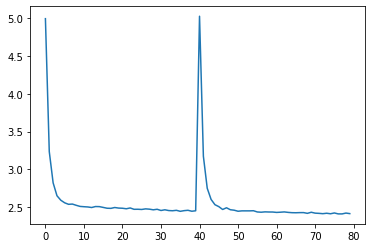

training accuracy: 


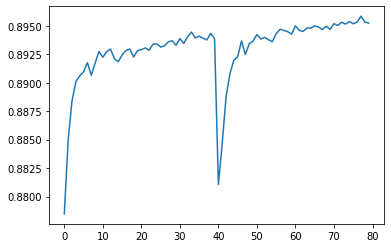

argmax recall: 


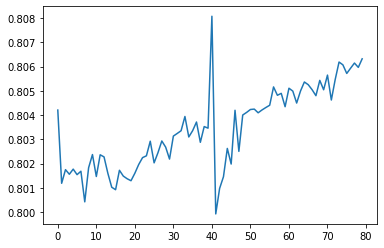

sample recall: 


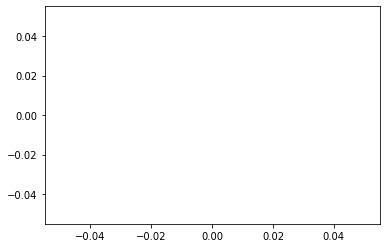

In [0]:


print("seq2seq is trained")

print("training loss: ")
plt.plot(train_losses)
plt.show()
plt.close()
print("training accuracy: ")
plt.plot(train_accuracies)
plt.show()
plt.close()
print("argmax recall: ")
plt.plot(correction_argmax_recall)
plt.show()
plt.close()
print("sample recall: ")
plt.plot(correction_sample_recall)
plt.show()
plt.close()


romance_questions = ["hello , nice to meet you !",
                     "hi , how are you ?",
                     "hi pretty one !",
                     "what is on your mind right now ?",
                     "what do you want from me ?",
                     "do you want something from me ?",
                     "what is your name swettie ?",
                     "do you like to play ?",
                     "would you play with me ?",
                     "am i handsome ?",
                     "what is on your mind ?"]



def talk_to_me(test_phrases, sampling = False):
    converted_test_phrases = []
    converted_test_answers = []
    test_answers = []

    with tf.device("cpu:0"):

        for phrase in test_phrases:
            phrase = phrase.strip(" ")
            phrase_words = phrase.split(" ")
            skip = False
            phrase_words = ["BEGIN"] + phrase_words + ["END"]
            if not skip:
                predicted = seq2seq.predict(phrase_words, sampling = sampling)
                test_answers.append(predicted)

    for i in range(len(test_phrases)):
        phrase = test_phrases[i].strip(" ").split(" ")

        answer = test_answers[i]
        converted_answer = ""
        for word in answer:
            converted_answer += word
            converted_answer += " "

        converted_test_answers.append(converted_answer)  

    for i in range(len(test_phrases)):
        print(test_phrases[i])
        print(converted_test_answers[i])
        print("\n")  





In [0]:

talk_to_me(romance_questions, sampling = True) #old

hello , nice to meet you !
hi , happy to meet you too ! 


hi , how are you ?
i am fine , thank you ! 


hi pretty one !
hey . 


what is on your mind right now ?
i do not know , dignan . 


what do you want from me ?
your love . 


do you want something from me ?
sure . 


what is your name swettie ?
do not give her your name . 


do you like to play ?
i do not know . 


would you play with me ?
sure . 


am i handsome ?
you can not be out . 


what is on your mind ?
i do not know ... this dna . 




In [0]:
talk_to_me(["how do you know this ?"], sampling = False)

how do you know this ?
i know . 




In [0]:
from google.colab import files
import h5py
import pickle

def download_weights(weights):

    weight_file_name = "weights2_final_v3." + \
                        str(MIN_TOKEN_FREQ) + "." + \
                         str(MAX_TOKENS_X) + "." + \
                         str(MAX_TOKENS_Y) + "." + \
                         "all_except." * int(WITH_EXCEPTION) + \
                         GENRES + ".h5"

    with h5py.File(weight_file_name, "w") as h5f:
        i = 0
        for weight in weights:
            group = h5f.create_group(str(i))
            i += 1
            j = 0
            for kernel in weight:
                group.create_dataset(str(j), data=kernel)
                j += 1
    h5f.close()
    files.download(weight_file_name)

with tf.device("cpu:0"):
    weights = seq2seq.save()


words_file_name = "words2_final_v3" + "." + str(MIN_TOKEN_FREQ) + \
                     "." + str(MAX_TOKENS_X) + "." + str(MAX_TOKENS_Y) + \
                      "." + "all_except." * int(WITH_EXCEPTION) + \
                      GENRES + ".dict"

with open(words_file_name, "wb") as dict_file:
    pickle.dump(word_dict, dict_file)

download_weights(weights)
files.download(words_file_name)

And last step is saving weights and words dictionary tokens of trained seq2seq model, code above saves weights in fucntion and two arrays of word indices:
first array is array of indices of words that saved seq2seq model is trained on in twitter 50-d embeddings array with 3 adititional words ("EMPTY" with index 0, "START" with index 1 and "END" with index 2), all 3 words are added at the begining of embeddings array.
second array is array of word tokens in seq2seq2 model dictionary with which seq2seq model operates, every token at index i in this array corresponds to word index at the same index in first array, so recreated dictionary of saved model will have as keys words from embeddings file with 3 additional words at the begining at indices from first array and as values will have tokens from second array.